In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from datetime import datetime, timedelta
import pickle
import ipywidgets as widgets
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({'figure.autolayout': True})

## GPS_Stations Class
The `GPS_Stations` class is a wrapper for a data dictionary, `{Name: time series data}`. The time series data is an Nx4 ndarray, where N is the number of dates, from 2011/4/1 to 2016/12/31. The 4 columns correspond to date (`datetime` type), east, north and up components (all `float` type).

In [2]:
class GPS_Stations():
    def __init__(self):
        self.data = {}
    def add(self, station_name, date, x, y, z):
        if station_name in self.data:
            # if the station is already in the data dictionary, append a new row of data [date,x,y,z]
            self.data.update( {station_name : np.append( self.data[station_name], np.array([date,x,y,z]).reshape(1,4), axis=0 ) } )
        else: # if first time adding this station, create a key:data pair.
            self.data.update( {station_name : np.array([date,x,y,z]).reshape(1,4)} )

## Loading Data
If a pickled data object exists, load and use it as an instance of `GPS_Stations` class named `Korea_GPS_Stations`. If not, i.e., `DATA_EXISTS==False`, read the data files retrived from the repository associated with (Kim et al., Tectonics, 2018) to create and populate an instance of `GPS_Stations` named `Korea_GPS_Stations`. 

If a pickled `GPS_Stations` data object exists, the first cell will just load it rather than read the coordinate files again. In this case, `DATA_EXISTS` is set to `True` so that the second cell can be skipped.

If such a pickled object does not exist (`DATA_EXISTS == False`), the second cell below should be run. Then, the newly created object is pickled for later use.

In [3]:
DATA_EXISTS = False
try: 
    Korea_GPS_Stations = pickle.load( open( "Korea_GPS_Stations.p", "rb" ) )
    if Korea_GPS_Stations:
        DATA_EXISTS = True
        print("Data object exists")
except FileNotFoundError:
    print("Failed to load the pickled data. Move to the next cell.")

Data object exists


In [4]:
if DATA_EXISTS == False:
    data_dir = "GPS Daily Coordinate data (2011 to 2016)/Coordinate"
    Korea_GPS_Stations = GPS_Stations()
    years = np.arange(2011,2017)
    #print(years)
    networks = np.array(['KASI', 'NGII'])
    #print(networks)
    for yr in years:
        for nt in networks:
            path = "./{0:s}/{1}/{2}".format(data_dir, yr, nt)
            #print(path)
            for f in os.listdir(path):
                fname = "{0}/{1}".format(path,f)
                fi = open(fname, 'r')
                lines = fi.readlines()
                date = np.datetime64(lines[2].split()[5]).astype(datetime)
                if date == datetime(2012,6,1): # exclude outlier
                    continue
                linecount = 7
                for line in lines[7:]:
                    linecount += 1
                    fields = line.split()
                    fieldnum = len(fields)
                    if fieldnum == 6:   # valid data without 'Name' field
                        name = fields[1]
                        x = float(fields[2])
                        y = float(fields[3])
                        z = float(fields[4])
                    elif fieldnum == 7: # valid data with all the fields filled
                        name = fields[1]
                        x = float(fields[3])
                        y = float(fields[4])
                        z = float(fields[5])
                    elif fieldnum == 5:   # invalid data with 0 0 0 coordinates
                        continue  # move on to the next line
                    elif fieldnum <= 1: # bottom blank lines
                        break     # stop processing this file
                    else:               # None of the above. Abort
                        print("Problem with line {0} in {1}".format(linecount, fname))
                        break     # stop processing this file
                    #print(fname, line)
                    Korea_GPS_Stations.add(name, date, x, y, z)
                fi.close()

    # Store the data object for quicker loading later
    with open("Korea_GPS_Stations.p", "wb") as handle:
        pickle.dump(Korea_GPS_Stations, handle, protocol=pickle.HIGHEST_PROTOCOL)
    DATA_EXISTS = True

## Data cleaning

### Jump removal
A function `remove_jump` is used for removing a jump in a time series.

In [5]:
def remove_jump( stations, s, jump_date1, jump_date2 ):
    d = stations.data[s][:,0]
    e = stations.data[s][:,1]
    n = stations.data[s][:,2]
    u = stations.data[s][:,3]

    jump_ind1 = np.where(d == jump_date1)[0]
    jump_ind2 = np.where(d == jump_date2)[0]
    after_jump = d > jump_date1
    
    #print(jump_ind1, jump_ind2)
    #print(jump_ind2[0], jump_ind2[0]+5, stations.data[s][jump_ind2[0]:(jump_ind2[0]+5),1:4])
    avg_period = 20
    if s == 'JEOJ':
        avg_period = 120
    jumpval = np.sum(stations.data[s][jump_ind2[0]:(jump_ind2[0]+avg_period),1:4],\
                     axis=0)/avg_period
    print(jumpval)
    jump = jumpval - stations.data[s][jump_ind1,1:4]
    #jump = stations.data[s][jump_ind2,1:4]-stations.data[s][jump_ind1,1:4]
    #print(jump.shape)
    new_e = np.where(after_jump, e-jump[0,0], e)
    new_n = np.where(after_jump, n-jump[0,1], n)
    new_u = np.where(after_jump, u-jump[0,2], u)
    #plt.plot(d, new_u, color='red')
    #plt.plot(d, u)

    stations.data[s][:,1] = new_e
    stations.data[s][:,2] = new_n
    stations.data[s][:,3] = new_u

### Remove stations with incomplete time period

Most of the stations have a position time series spanning 2011/04/01 to 2016/12/31.
Any station with a shorter data span is removed from the `Korea_GPS_Stations object`'s data dictionary.

In [8]:
# Verify the loaded data if desired.
stations_to_discard = []
for s in Korea_GPS_Stations.data.keys():
    if Korea_GPS_Stations.data[s][0,0] > datetime(2011,4,1).date() or \
        Korea_GPS_Stations.data[s][-1,0] < datetime(2016,12,31).date():
        stations_to_discard.append(s)
for s in stations_to_discard:
    Korea_GPS_Stations.data.pop(s)
    
scounter = 0
for s in Korea_GPS_Stations.data.keys():    
    scounter += 1
    print(scounter, s, Korea_GPS_Stations.data[s][0,0], Korea_GPS_Stations.data[s][-1,0])

1 DAEJ 2011-04-01 2016-12-31
2 JEJU 2011-04-01 2016-12-31
3 KOHG 2011-04-01 2016-12-31
4 MKPO 2011-04-01 2016-12-31
5 MLYN 2011-04-01 2016-12-31
6 SBAO 2011-04-01 2016-12-31
7 SKCH 2011-04-01 2016-12-31
8 SKMA 2011-04-01 2016-12-31
9 ANSG 2011-04-01 2016-12-31
10 BOEN 2011-04-01 2016-12-31
11 CHCN 2011-04-01 2016-12-31
12 CHEN 2011-04-01 2016-12-31
13 CHJU 2011-04-01 2016-12-31
14 CHLW 2011-04-01 2016-12-31
15 CHNG 2011-04-01 2016-12-31
16 CHSG 2011-04-01 2016-12-31
17 CHWN 2011-04-01 2016-12-31
18 CHYG 2011-04-01 2016-12-31
19 CNJU 2011-04-01 2016-12-31
20 DOND 2011-04-01 2016-12-31
21 EOCH 2011-04-01 2016-12-31
22 GOCH 2011-04-01 2016-12-31
23 GSAN 2011-04-01 2016-12-31
24 HADG 2011-04-01 2016-12-31
25 HOMI 2011-04-01 2016-12-31
26 HONC 2011-04-01 2016-12-31
27 INCH 2011-04-01 2016-12-31
28 INJE 2011-04-01 2016-12-31
29 JAHG 2011-04-01 2016-12-31
30 JEOJ 2011-04-01 2016-12-31
31 JINJ 2011-04-01 2016-12-31
32 JUNG 2011-04-01 2016-12-31
33 JUNJ 2011-04-01 2016-12-31
34 KANR 2011-04-01 

### Removing outliers with Extended Linear Trajectory Models

#### `get_station_data()`
A function that returns date, easting, northing and up for a `station` from `start_datetime` to `end_datetime`.

#### `plot_selected_station()`
A function that plots easting, northing and up for a `selected_station` from `start_datetime` to `end_datetime`.

#### `eltm()` and `get_eltm()`
Implementation of Extended Linear Trajectory Model (Bevis and Brown, J.Geodesy, 2014):

$
\mathbf{x}(t) = \sum_{i=1}^{np+1} \mathbf{p}_{i}(t-t_{R})^{i-1} +
\sum_{j=1}^{nJ} \mathbf{b}_{j}H(t-t_{j}) + 
\sum_{k=1}^{nF} \left( \mathbf{s}_{k}\sin(\omega_{k}t) + \mathbf{c}_{k}\cos(\omega_{k}t) \right) +
\sum_{m=1}^{nT} \mathbf{a}_{m}\log(1+\Delta t_{m}/T_{m}).
$

Here, we consider only the following model with 11 parameters:
$
\mathbf{x}(t) = (pt+q) +
\left( \mathbf{s}_{a}\sin(\omega_{a}t) + \mathbf{c}_{a}\cos(\omega_{a}t) \right) +
\left( \mathbf{s}_{h}\sin(\omega_{h}t) + \mathbf{c}_{h}\cos(\omega_{h}t) \right) +
a\log(1+\Delta t_{m}/T_{m}).
$

The difference between `eltm` and `get_eltm` is that `eltm` takes `days` as `float` while `get_eltm` internally converts `datetime` to `float`.

#### `eltm_linear_only` and `get_eltm_linear_only()`
Only the linear component is assumed to contribute to tectonic displacements.

In [20]:
def get_station_data( station, start_datetime=datetime(2011, 4, 1), end_datetime=datetime(2016, 12, 31) ):
    """
    Retrieves a station's data from start_datetime to end_datetime (all inclusive)
    and returns 4 arrays of daily time series, date, easting, northing and up.
    Note that position components are shifted to be zero on the starting date.
    """
    data = Korea_GPS_Stations.data[station]
    start_date = start_datetime.date() 
    if start_date < data[0,0]:
        start_date = data[0,0]
        print("Warning: Start date reset to {0}".format(start_date))
    end_date = end_datetime.date()
    if end_date > data[-1,0]:
        end_date = data[-1,0]
        print("Warning: End date reset to {0}".format(end_date))
    print(start_date, data[0,0], end_date, data[-1,0])
    
    datemask = np.logical_and(data[:,0] >= start_date, data[:,0] <= end_date)
    start_index = np.where(data[:,0] == start_date)[0]
    print("start_index = {}".format(start_index))
    if len(start_index) != 1:
        print("start_index = ", start_index)
        print("first and last date in the data are ", data[0,0], data[-1,0])
    
    date = data[datemask,0]
    easting  = data[start_index,1] - data[datemask,   1]
    northing = data[datemask,   2] - data[start_index,2]
    up       = data[datemask,   3] - data[start_index,3]
    print(data[start_index,2], data[start_index,3])
    print(len(date), len(data[:,0]))
    
    return date, easting, northing, up

def plot_selected_station( selected_station, start_datetime=datetime(2011, 9, 1), 
                          end_datetime=datetime(2016, 9, 30) ):
    """
    plot the east, north and up position time series for a selected station 
    from a start date until an end date.
    """
    d, e, n, u = get_station_data(selected_station, start_datetime, end_datetime)

    fig = plt.figure()
    ax = fig.add_subplot()

    ax.plot(d, e, 'ro', markersize=2, label="east")
    ax.plot(d, n, 'go', markersize=2, label="north")
    ax.plot(d, u, 'bo', markersize=2, label="up")
    ax.set_title(selected_station)
    ax.set_ylabel('Displacement (m)')
    ax.set_ylim((-0.1,0.1))
    ax.legend(loc=2)

In [10]:
def eltm(days, p, q, sa, sp, ca, cp, sh, shp, ch, chp, a):
    from numpy import sin, cos, log   
    wa = 2.0*np.pi/365.0  # annual frequency
    wh = 4.0*np.pi/365.0  # semi-annual frequency
    # Number of days since Tohoku Eq (March 11, 2011) until April 1, 2011.
    dd_eq = 21.0 # = (datetime(2011, 4, 1)-datetime(2011, 3, 11)) / timedelta(days=1)
    dd = 2.0*(days + dd_eq)/365.0 # time scale: half a year
    disp = (p*days+q) + sa * sin(wa*(days-sp)) + ca * cos(wa*(days-cp)) \
            + sh * sin(wh*(days-shp)) + ch * cos(wh*(days-chp)) + a * log(1.0+dd)
    return disp

def get_eltm(day, coeff):
    days = day.astype(float)
    p, q, sa, sp, ca, cp, sh, shp, ch, chp, a = coeff
    from numpy import sin, cos, log   
    wa = 2.0*np.pi/365.0  # annual frequency
    wh = 4.0*np.pi/365.0  # semi-annual frequency
    # Number of days since Tohoku Eq (March 11, 2011) until April 1, 2011.
    dd_eq = 21.0 # = (datetime(2011, 4, 1)-datetime(2011, 3, 11)) / timedelta(days=1)
    dd = 2.0*(days + dd_eq)/365.0 # time scale: half a year
    disp = (p*days+q) + sa * sin(wa*(days-sp)) + ca * cos(wa*(days-cp)) \
            + sh * sin(wh*(days-shp)) + ch * cos(wh*(days-chp)) + a * log(1.0+dd)
    return disp

In [11]:
def eltm_linear_only(days, p, q):
    disp = p*days+q
    return disp

def get_eltm_linear_only(day, coeff):
    days = day.astype(float)
    p, q = coeff
    disp = p*days+q
    return disp

In [12]:
def plot_raw_e_eltm( selected_station, d, e, n, u, e_eltm, cleaned_station_data, popt ):
    fig, axs = plt.subplots(1,2)
    for ax in axs:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2.0)
    fig.set_figheight(4)
    fig.set_figwidth(9)

    axs[0].plot(d,e)
    axs[0].tick_params(direction='out', length=6, width=2, labelsize=12)
    axs[0].tick_params(which='minor', direction='out', length=4, width=2)
    axs[0].set_title("{0}: Raw data".format(selected_station), size=16)
    axs[0].set_xlabel('Time', size=14)
    axs[0].set_ylabel('Easting (m)', size=14)
    axs[0].grid()

    # Plot both data and the fitting function
    from numpy import log
    axs[1].plot(cleaned_station_data['days'], cleaned_station_data['e'],\
                marker='.', markeredgecolor='gray', markerfacecolor='gray', linestyle='none', alpha=1.0, label='Cleaned data')
    axs[1].set_ylim((-0.05,0.2))
    axs[1].plot(cleaned_station_data['days'], e_eltm, color='tab:red',\
            linewidth=2, label='ELTM')
    axs[1].plot(cleaned_station_data['days'], popt[0]*cleaned_station_data['dfloat'] + popt[1], \
             color='tab:orange', linewidth=2, label='linear')
    axs[1].plot(cleaned_station_data['days'], popt[0]*cleaned_station_data['dfloat'] + popt[1] \
             + popt[10]*log(1.0+2.0*(cleaned_station_data['dfloat'] + 20.0)/365.0),\
            color='tab:green', linewidth=2, label='linear+log')
    axs[1].tick_params(direction='out', length=6, width=2, labelsize=12)
    axs[1].tick_params(which='minor', direction='out', length=4, width=2)
    axs[1].set_title("{0}: Cleaned data and ELTM".format(selected_station), size=16)
    axs[1].set_xlabel('Time', size=14)
    axs[1].set_ylabel('Easting (m)', size=14)
    legend = axs[1].legend(loc=4, fontsize=12)
    legend.get_frame().set_linewidth(2)
    axs[1].grid()

    plt.savefig("./ELTM_plots/Cleaned_ELTM_{0}.png".format(selected_station))
    plt.close(fig)

In [13]:
def plot_raw_e_eltm_linear_only( selected_station, d, e, n, u, e_eltm, cleaned_station_data, popt ):
    fig, axs = plt.subplots(1,2)
    for ax in axs:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2.0)
    fig.set_figheight(4)
    fig.set_figwidth(9)

    axs[0].plot(d,e)
    axs[0].tick_params(direction='out', length=6, width=2, labelsize=12)
    axs[0].tick_params(which='minor', direction='out', length=4, width=2)
    axs[0].set_title("{0}: Raw data".format(selected_station), size=16)
    axs[0].set_xlabel('Time', size=14)
    axs[0].set_ylabel('Easting (m)', size=14)
    axs[0].grid()

    # Plot both data and the fitting function
    from numpy import log
    axs[1].plot(cleaned_station_data['days'], cleaned_station_data['e'],\
                marker='.', markeredgecolor='gray', markerfacecolor='gray', linestyle='none', alpha=1.0, label='Cleaned data')
    axs[1].set_ylim((-0.05,0.2))
    axs[1].plot(cleaned_station_data['days'], e_eltm, color='tab:red',\
            linewidth=2, label='ELTM')
    axs[1].plot(cleaned_station_data['days'], popt[0]*cleaned_station_data['dfloat'] + popt[1], \
             color='tab:orange', linewidth=2, label='linear')
    axs[1].tick_params(direction='out', length=6, width=2, labelsize=12)
    axs[1].tick_params(which='minor', direction='out', length=4, width=2)
    axs[1].set_title("{0}: Cleaned data and ELTM".format(selected_station), size=16)
    axs[1].set_xlabel('Time', size=14)
    axs[1].set_ylabel('Easting (m)', size=14)
    legend = axs[1].legend(loc=4, fontsize=12)
    legend.get_frame().set_linewidth(2)
    axs[1].grid()

    # plt.savefig("./ELTM_plots/Cleaned_ELTM_{0}.png".format(selected_station))
    plt.show()
    # plt.close(fig)

### Main function that computes ELTM coefficients

In [14]:
def get_eltm_as_Kim_etal_2018( selected_station, start_datetime, end_datetime ):
    """
    1. Retrieve days, east, north and up time series at a selected station 
    using 'get_station_data()'; 2. remove outlier relative to the full ELTM
    fitting; and 3. calculate coefficients for linear fitting to the cleaned
    data.
    Input: 
        - selected_station: A dictionary pairng selected station names
                            with raw position time series
        - start_datetime, end_datetime: start and end date of 'datetime' type
    Output:
        - ecoeff, ecov: ELTM coefficients and the associated covariance for
                        east components
        - ncoeff, ncov: for north components    
    """    
    d, e, n, u = get_station_data(selected_station, start_datetime, end_datetime)

    # Full ELTM fitting for outlier removal
    from scipy.optimize import curve_fit
    days_float = (d-start_datetime.date()) / timedelta(days=1)
    ecoeff, ecov = curve_fit(eltm, days_float, e)
    e_eltm = get_eltm(days_float, ecoeff)
    e_detrended = e - e_eltm
    ncoeff, ncov = curve_fit(eltm, days_float, n)
    n_eltm = get_eltm(days_float, ncoeff)
    n_detrended = n - n_eltm

    # Outlier detect/removal
    std_e = np.std(e_detrended)
    max_deviations = 1.0
    not_outlier = np.abs(e_detrended) < (max_deviations * std_e)

    # Store cleaned station data for another ELTM fitting
    cleaned_station_data = {}
    cleaned_station_data['days'] = d[not_outlier]
    cleaned_station_data['e'] = e[not_outlier]
    cleaned_station_data['n'] = n[not_outlier]
    cleaned_station_data['u'] = u[not_outlier]
    cleaned_station_data['dfloat'] = days_float[not_outlier].astype('float64')

    # Acquire ELTM again with the cleaned data
    ecoeff, ecov = curve_fit(eltm_linear_only, cleaned_station_data['dfloat'], cleaned_station_data['e'])
    e_eltm = get_eltm_linear_only(cleaned_station_data['dfloat'], ecoeff)
    ncoeff, ncov = curve_fit(eltm_linear_only, cleaned_station_data['dfloat'], cleaned_station_data['n'])
    n_eltm = get_eltm_linear_only(cleaned_station_data['dfloat'], ncoeff)
    
    plot_raw_e_eltm_linear_only( selected_station, d, e, n, u, e_eltm, cleaned_station_data, ecoeff)
    
    return ecoeff, ecov, ncoeff, ncov

In [15]:
# Station selector widget
station_selector = widgets.Select(
    options=Korea_GPS_Stations.data.keys(),
    # NOTE (rclam): seems this has to be manually changed on my end when change GPS station
    value='DAEJ', 
    rows=10,
    description='Select a GPS station:',
    disabled=False
)
display(station_selector)

Select(description='Select a GPS station:', options=('DAEJ', 'JEJU', 'KOHG', 'MKPO', 'MLYN', 'SBAO', 'SKCH', '…

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1056]
[4050958.89199] [3861031.66751]
997 2053


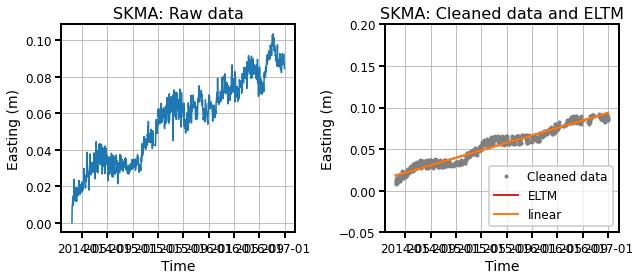

[7.98679998e-05 3.61046059e-03]


In [31]:
# When processing stations one by one:
selected_station = station_selector.value
# ecoeffA, ecovA, ncoeffA, ncovA = get_eltm_as_Kim_etal_2018( selected_station, datetime(2011,4,1), datetime(2013,3,11) )
ecoeffB, ecovB, ncoeffB, ncovB = get_eltm_as_Kim_etal_2018( selected_station, datetime(2014,3,14), datetime(2016,12,31) )
print(ecoeffA)

- Data > 1 $\sigma$ from the detrended filtered out.
- Notes on 22 problematic stations
    - 3 stations are retained after jump removed:
        - HOMI, MARA, ULLE
    - 19 stations discarded
        - WPWN: Station unidentified and location unknown
        - JEOJ: Jump removed unsatisfactorily.
        - SOUL: Data corrupted after early 2015?
        - TABK: Data corrupted after early 2012?
        - DOKD: Data corrupted?
        - SEJO: Data length shorter than others.
        - GOJE: Data length shorter than others.
        - KUSN: Data length shorter than others.
        - YODK: Data length shorter than others.
        - JIND: Data length shorter than others.
        - YOIN: Data length shorter than others.
        - SEJN: Data length shorter than others.
        - GANH: Data length shorter than others.
        - BONH: Data length shorter than others.
        - DONH: Data length shorter than others.
        - CHUL: Data length shorter than others.
        - DANJ: Data length shorter than others.
        - GOSG: Data length shorter than others.
        - HCHN: Data length shorter than others.


In [32]:
print(len(Korea_GPS_Stations.data.keys()))
problematic_stations = np.array(['JEOJ','SOUL','TABK','DOKD','SEJO','GOJE',\
                                 'KUSN','YODK','JIND','YOIN','SEJN','GANH',\
                                 'BONH','DONH','CHUL','DANJ','GOSG','HCHN','WPWN'])
for station in problematic_stations:
    try:
        Korea_GPS_Stations.data.pop(station)
        print("{0} removed".format(station))
    except KeyError:
        print("{0} already removed".format(station))
        continue
print(len(Korea_GPS_Stations.data.keys()))

59
JEOJ removed
SOUL removed
TABK removed
DOKD already removed
SEJO already removed
GOJE already removed
KUSN already removed
YODK already removed
JIND already removed
YOIN already removed
SEJN already removed
GANH already removed
BONH already removed
DONH already removed
CHUL already removed
DANJ already removed
GOSG already removed
HCHN already removed
WPWN removed
55


In [33]:
# Remove jump in some stations
remove_jump( Korea_GPS_Stations, 'HOMI', datetime(2013,8,4).date(), datetime(2013,8,5).date())
#remove_jump( Korea_GPS_Stations, 'JEOJ', datetime(2013,8,1).date(), datetime(2013,8,3).date())
remove_jump( Korea_GPS_Stations, 'MARA', datetime(2012,9,19).date(), datetime(2012,9,20).date())
remove_jump( Korea_GPS_Stations, 'ULLE', datetime(2014,9,16).date(), datetime(2014,9,17).date())

[-3287391.6835965 3978484.4780874997 3735219.035548]
[-3163444.7021489996 4311372.0558605 3464865.1484235004]
[-3309631.3318070006 3834554.7375344997 3863307.7731375]


2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4084614.80161] [3764026.85804]
700 2015


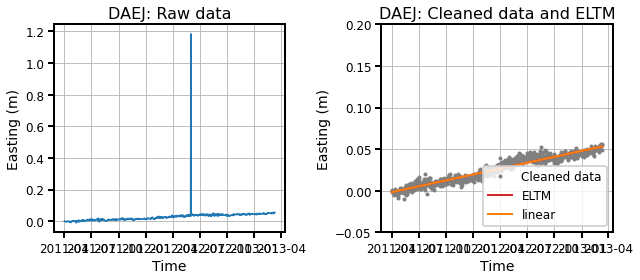

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1027]
[4084614.75443] [3764026.83272]
988 2015


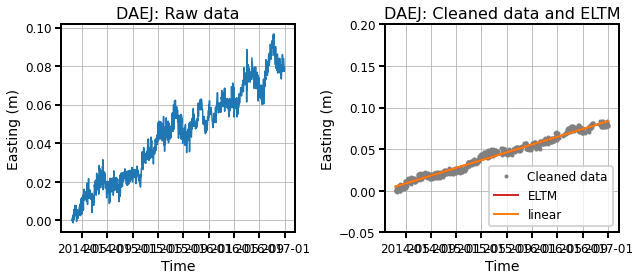

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4292560.05808] [3480970.89845]
709 2089


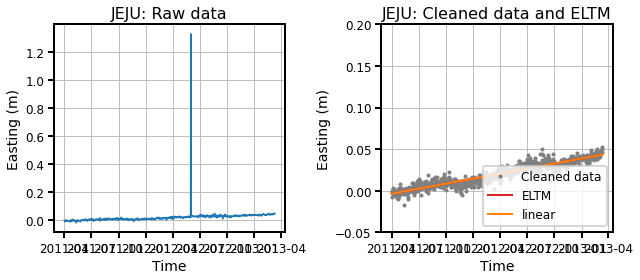

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1072]
[4292560.0192] [3480970.87234]
1017 2089


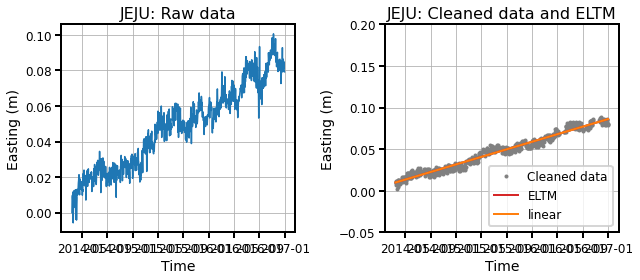

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4175914.92144] [3588087.45467]
706 2061


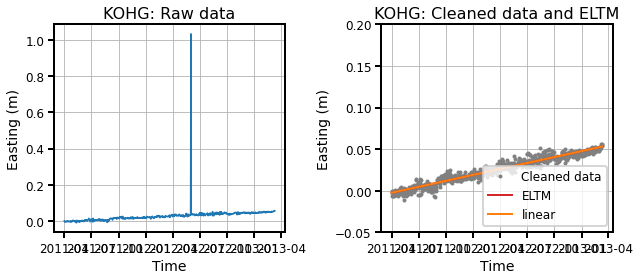

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1062]
[4175914.88005] [3588087.42478]
999 2061


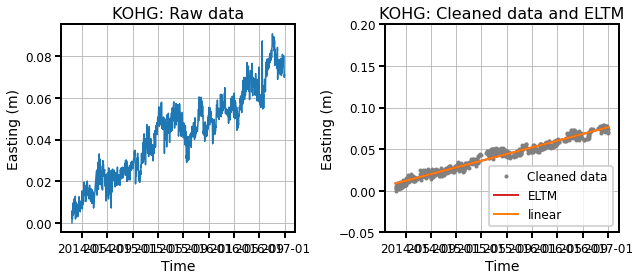

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4220348.61662] [3621241.20232]
706 2047


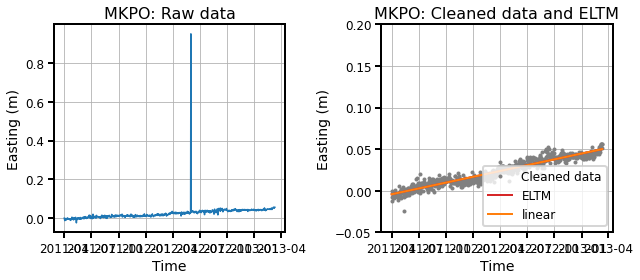

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1069]
[4220348.57982] [3621241.179]
978 2047


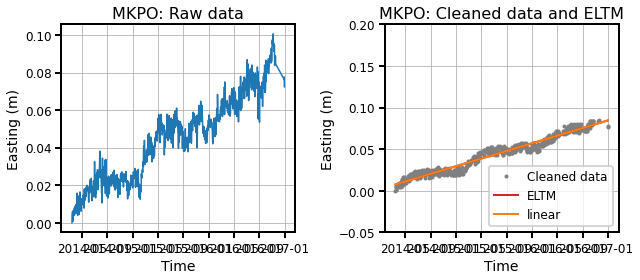

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4054963.16487] [3682413.29261]
709 2089


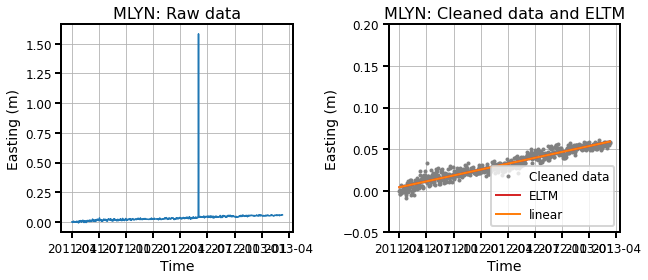

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1072]
[4054963.10862] [3682413.27525]
1017 2089


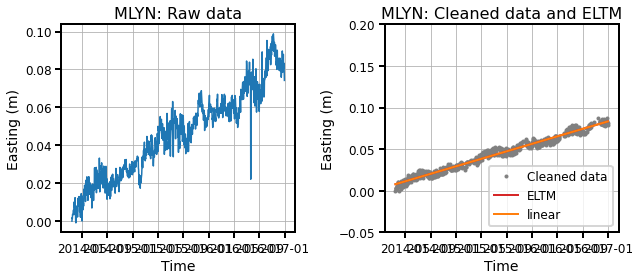

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3997975.65975] [3812384.38209]
698 2039


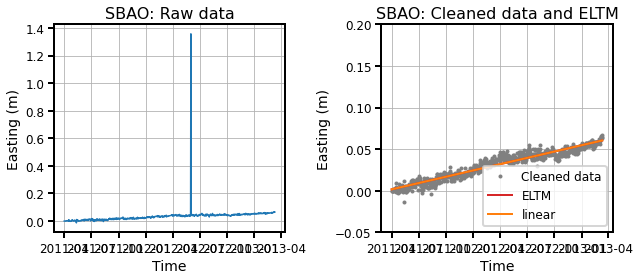

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1023]
[3997975.61229] [3812384.36616]
1016 2039


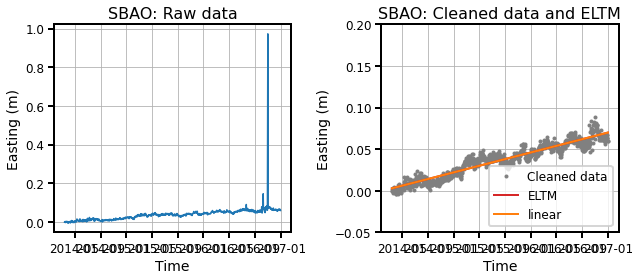

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3921458.12495] [3927386.11418]
706 2086


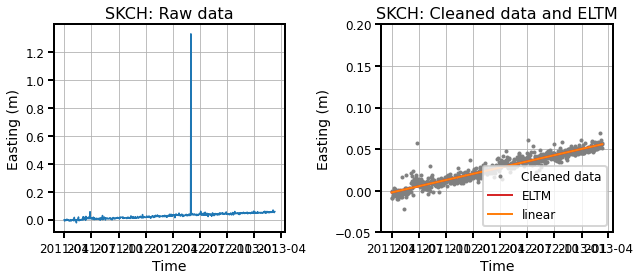

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1069]
[3921458.07411] [3927386.08566]
1017 2086


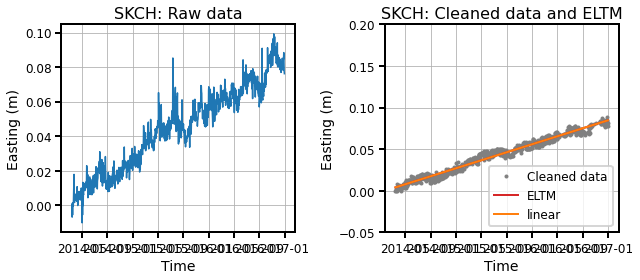

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4050958.93651] [3861031.69225]
707 2053


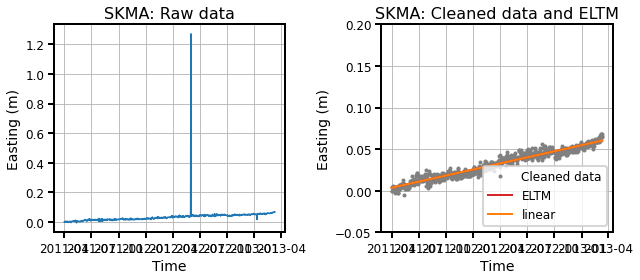

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1056]
[4050958.89199] [3861031.66751]
997 2053


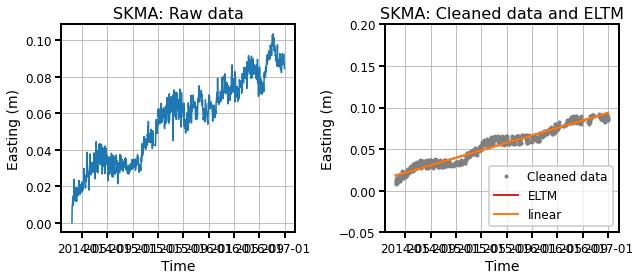

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4058167.27839] [3818526.3908]
706 2071


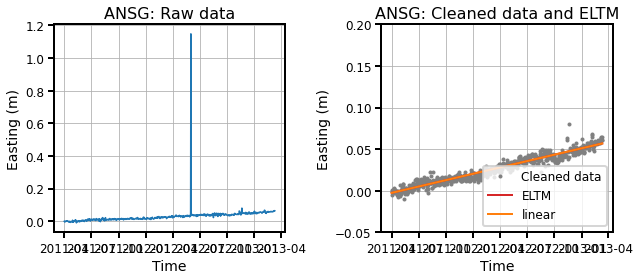

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1067]
[4058167.23697] [3818526.36446]
1004 2071


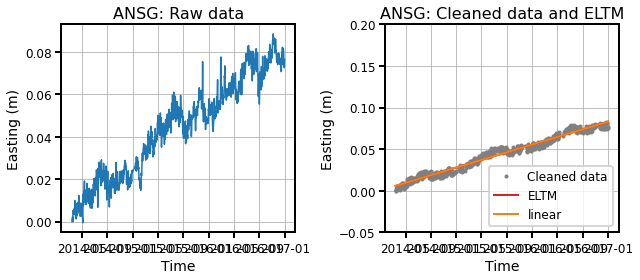

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4060585.44031] [3772023.04737]
710 2090


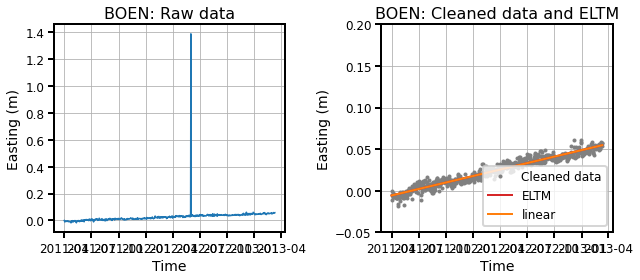

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4060585.39789] [3772023.02434]
1019 2090


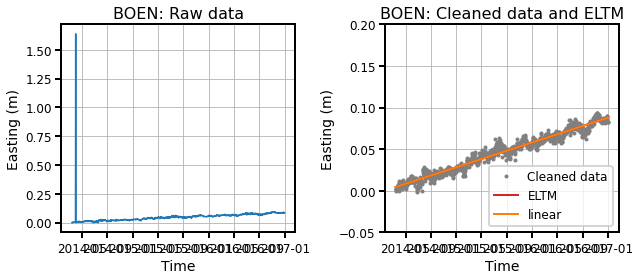

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3988333.11472] [3894101.8837]
709 2089


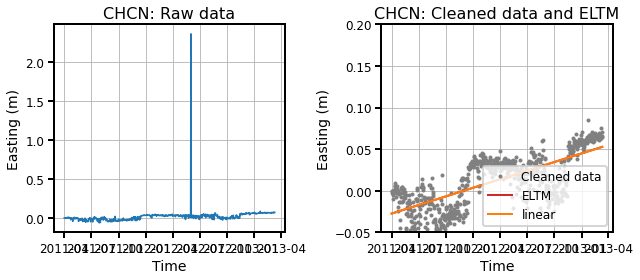

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1070]
[3988333.06987] [3894101.85856]
1019 2089


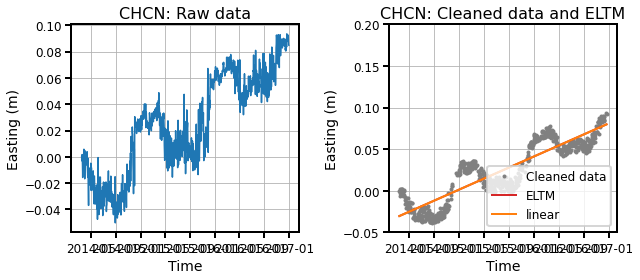

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4071232.60364] [3806614.11295]
705 2085


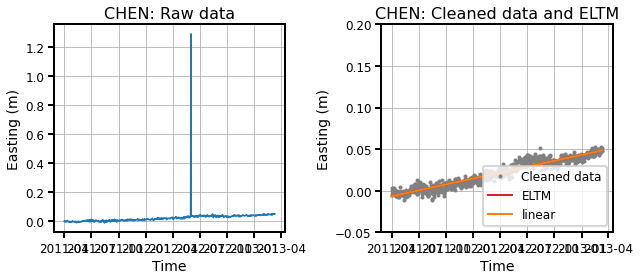

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1066]
[4071232.56305] [3806614.08353]
1019 2085


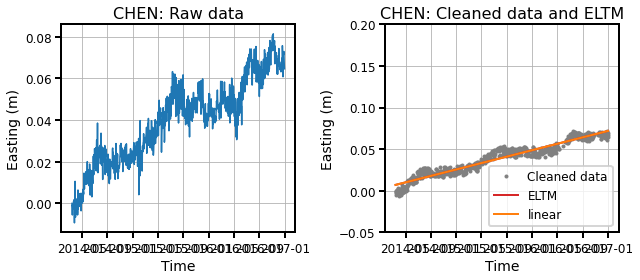

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4277489.47891] [3501649.96232]
709 2089


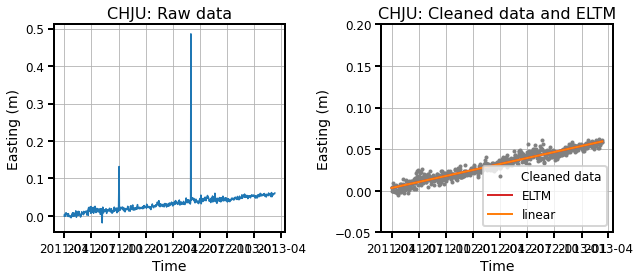

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1070]
[4277489.44355] [3501649.93826]
1019 2089


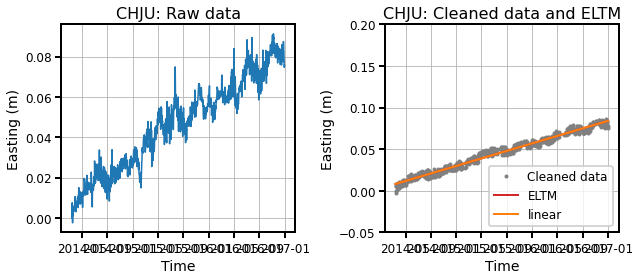

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3988270.75705] [3920005.46557]
710 2089


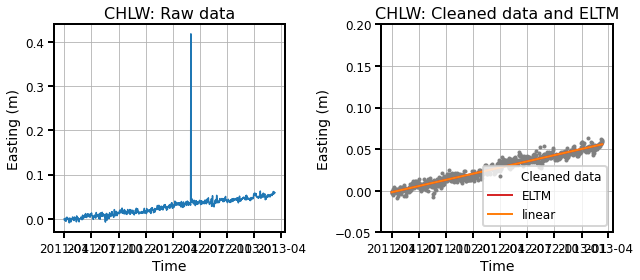

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[3988270.70915] [3920005.43702]
1018 2089


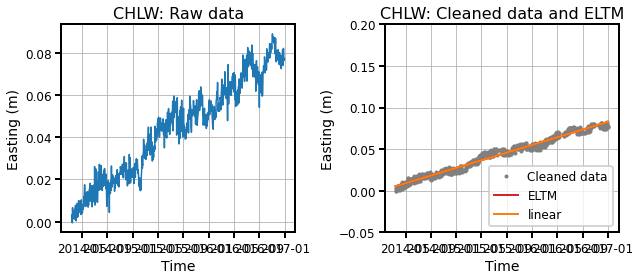

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4067916.28762] [3686212.0718]
706 2083


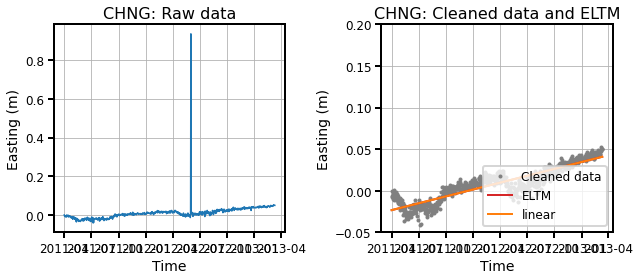

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1067]
[4067916.22628] [3686212.04317]
1016 2083


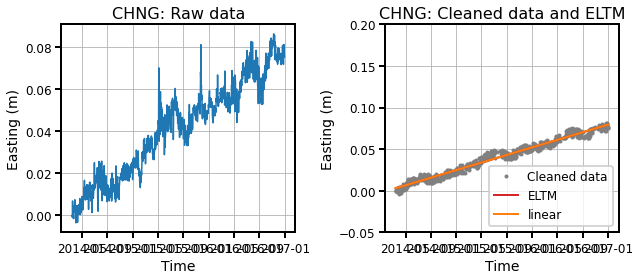

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3989513.5952] [3767338.52306]
707 2087


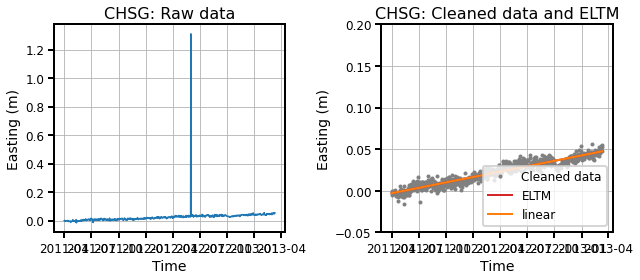

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1068]
[3989513.54342] [3767338.48833]
1019 2087


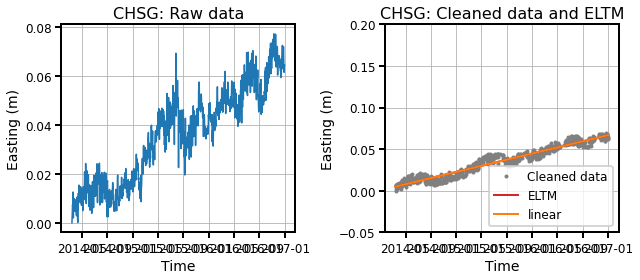

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4070678.32469] [3659345.23221]
710 2090


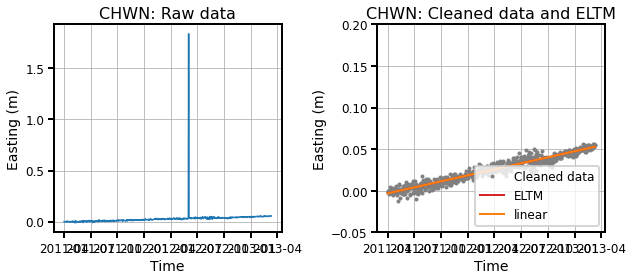

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4070678.2658] [3659345.21007]
1019 2090


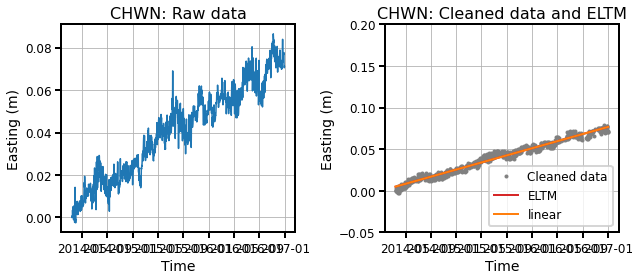

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4112486.44367] [3769348.58489]
710 2090


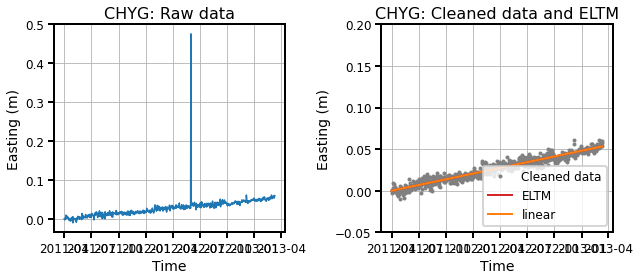

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4112486.38606] [3769348.55048]
1019 2090


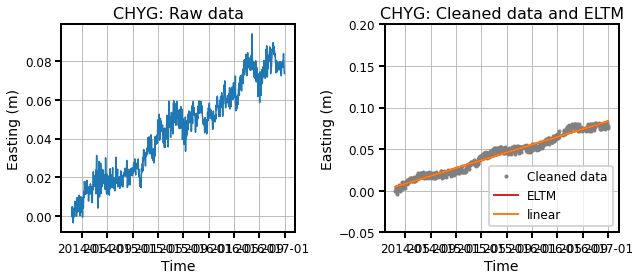

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4067949.6657] [3784300.4268]
686 2064


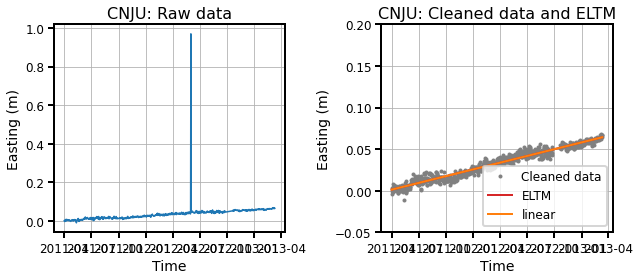

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1047]
[4067949.62943] [3784300.4057]
1017 2064


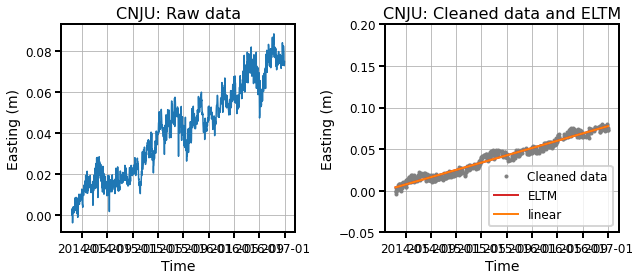

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4021287.58991] [3896957.45279]
700 2080


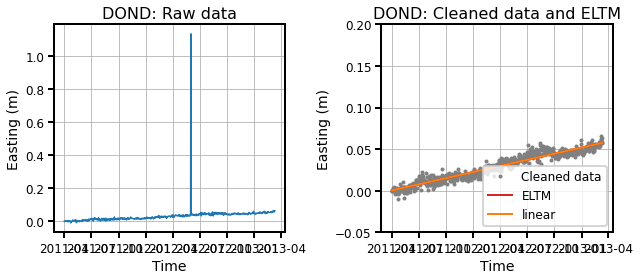

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1061]
[4021287.54678] [3896957.42326]
1019 2080


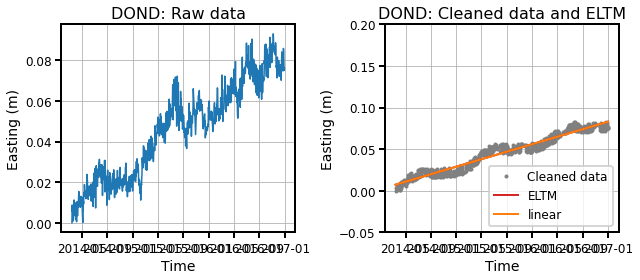

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4174489.75] [3739474.60132]
710 2090


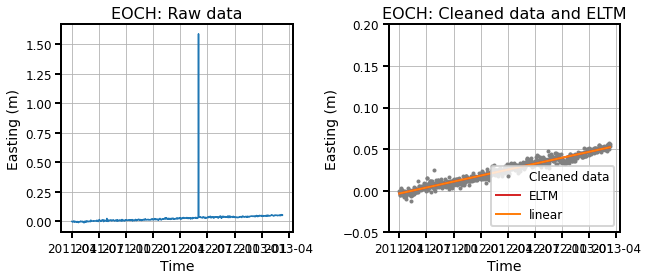

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4174489.70228] [3739474.57619]
1019 2090


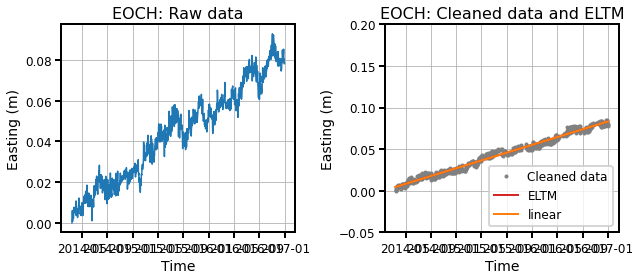

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4091157.78518] [3698444.74485]
710 2090


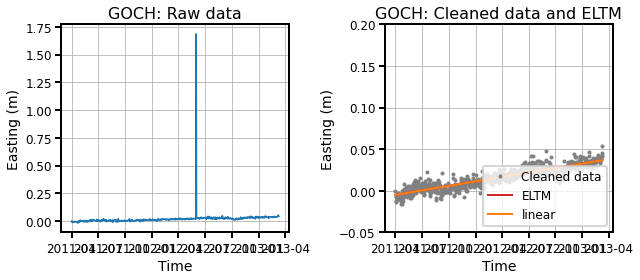

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4091157.72377] [3698444.70207]
1019 2090


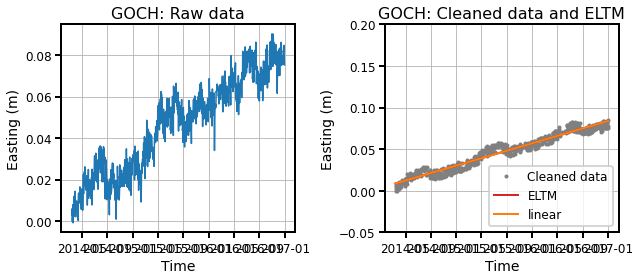

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4040303.89124] [3801190.07095]
710 2090


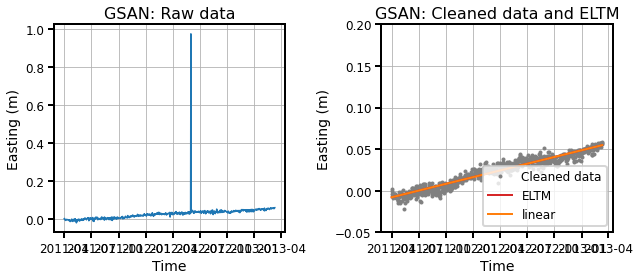

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4040303.84526] [3801190.04719]
1019 2090


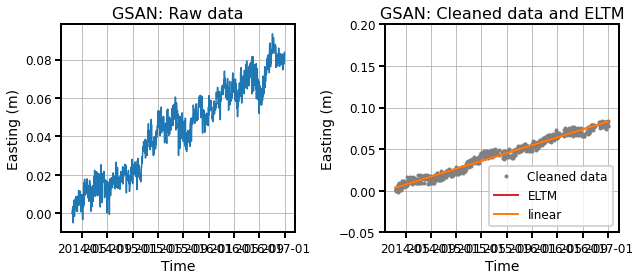

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4129777.71613] [3652656.4434]
691 2070


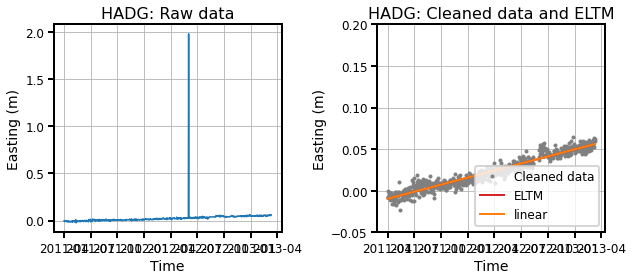

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1052]
[4129777.67083] [3652656.42009]
1018 2070


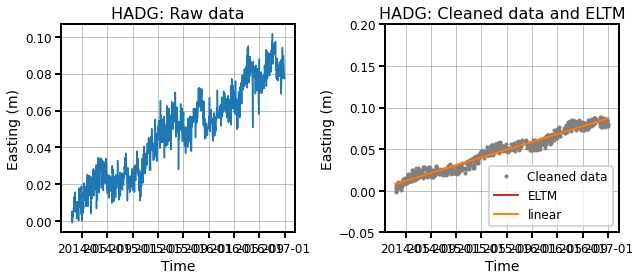

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3978484.43506] [3735218.97991]
710 2090


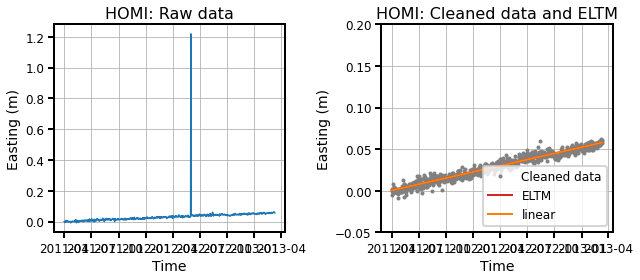

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[3978484.3687425004] [3735218.954712]
1019 2090


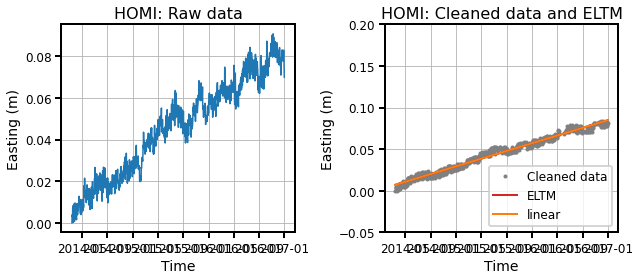

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3970877.63079] [3880183.21437]
710 2090


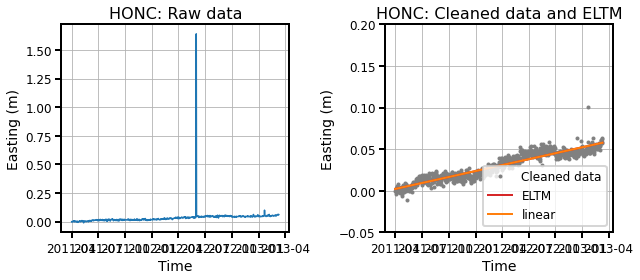

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[3970877.57513] [3880183.18007]
1019 2090


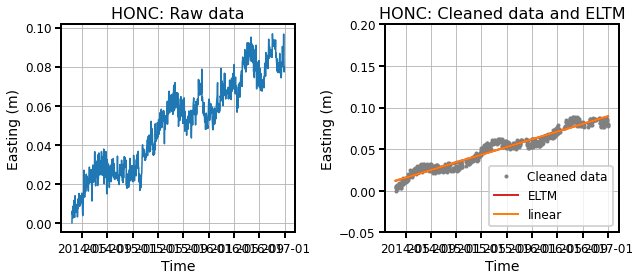

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4067230.91852] [3854557.38581]
708 2088


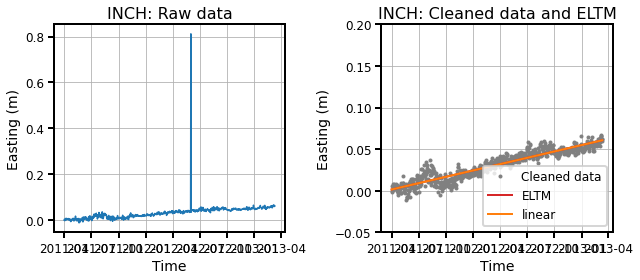

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1069]
[4067230.86644] [3854557.3519]
1019 2088


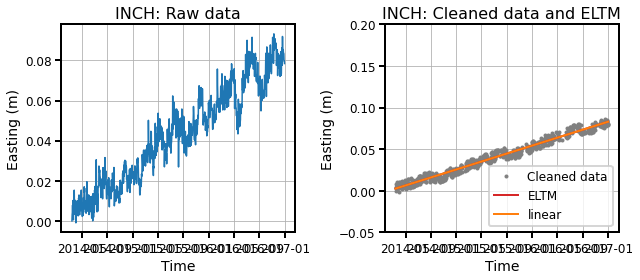

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3952779.59485] [3911675.58466]
708 2088


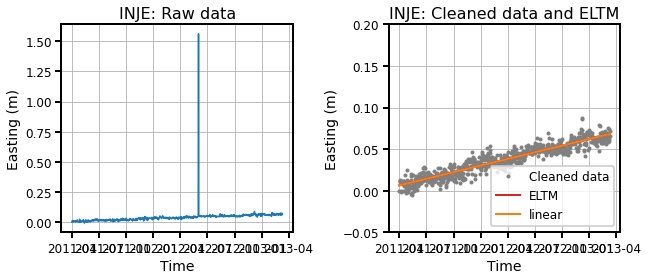

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1069]
[3952779.51786] [3911675.54627]
1019 2088


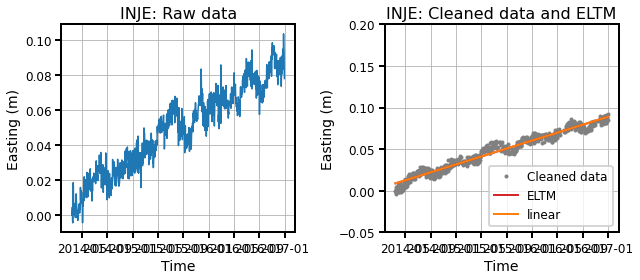

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4199245.32463] [3608372.3361]
708 2086


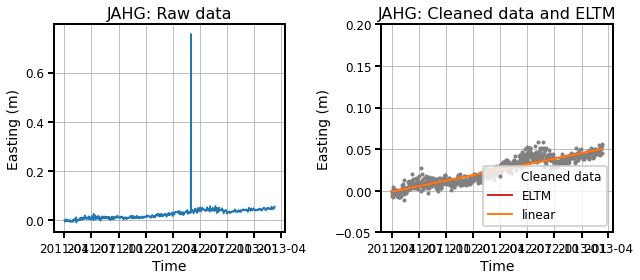

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1069]
[4199245.2672] [3608372.29998]
1017 2086


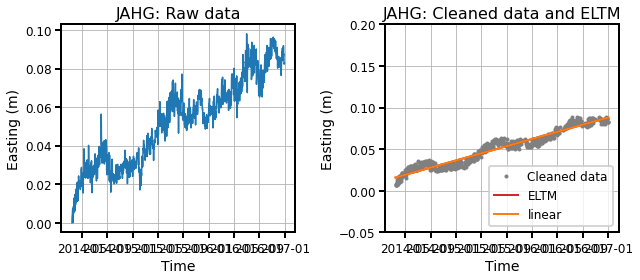

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4110225.53198] [3653650.378]
710 2090


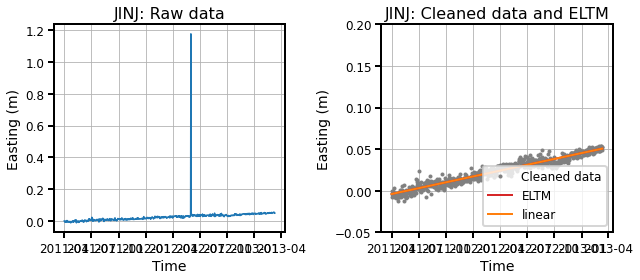

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4110225.47931] [3653650.34869]
1019 2090


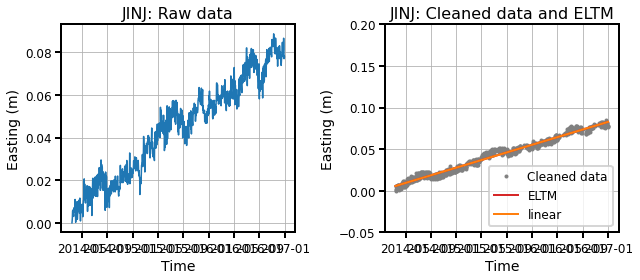

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4146816.50926] [3694330.87901]
693 2072


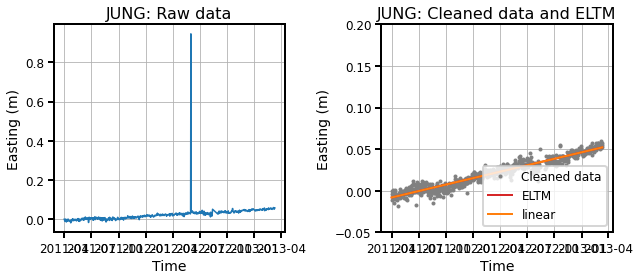

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1054]
[4146816.46695] [3694330.85248]
1018 2072


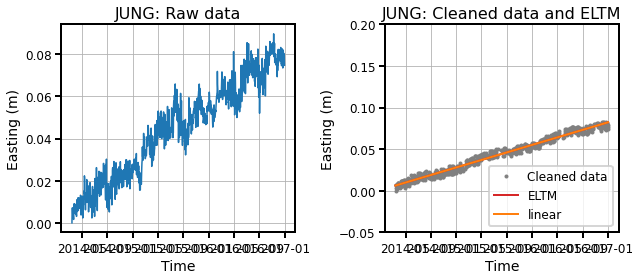

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4126580.41462] [3714170.09604]
688 2068


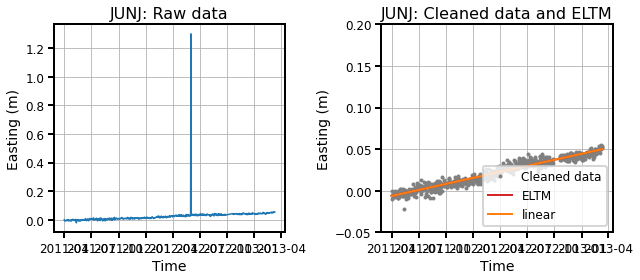

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1049]
[4126580.36447] [3714170.06538]
1019 2068


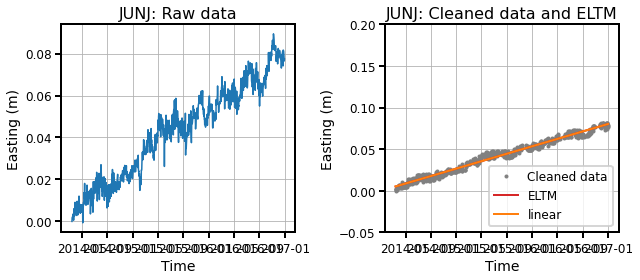

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3930397.00869] [3885411.85692]
710 2086


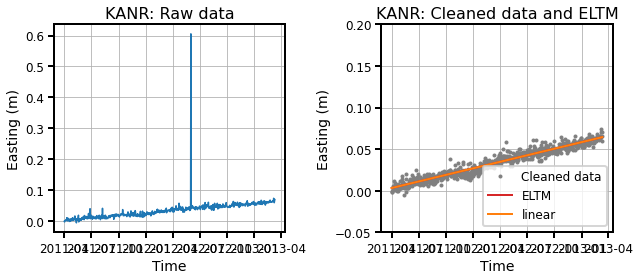

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[3930396.9563] [3885411.83412]
1015 2086


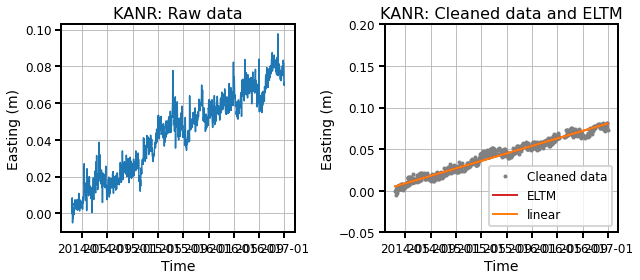

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4055951.95128] [3740570.76598]
710 2089


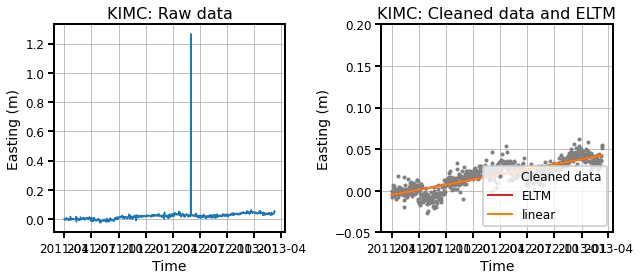

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1070]
[4055951.90051] [3740570.74189]
1019 2089


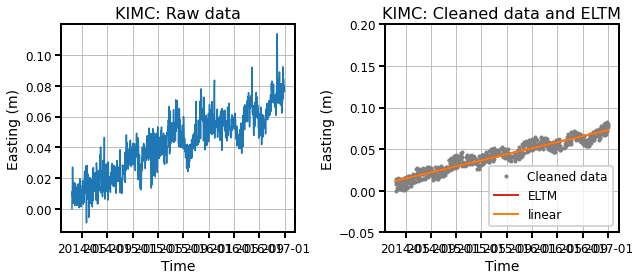

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4026954.21726] [3749223.2909]
708 2088


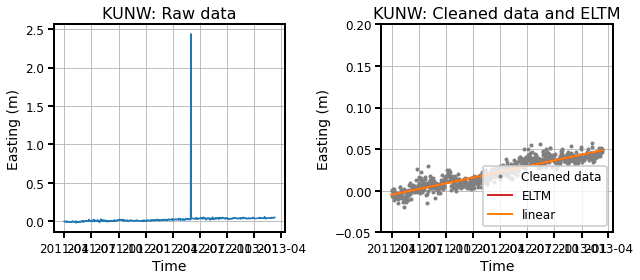

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1069]
[4026954.14564] [3749223.25013]
1019 2088


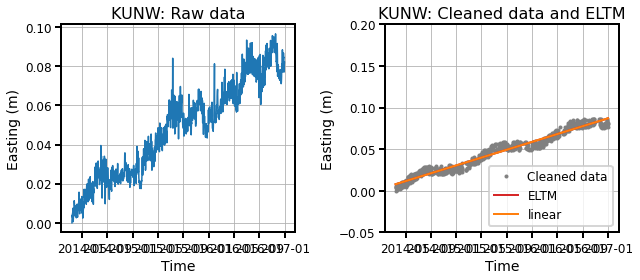

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4173081.71179] [3654100.91908]
710 2090


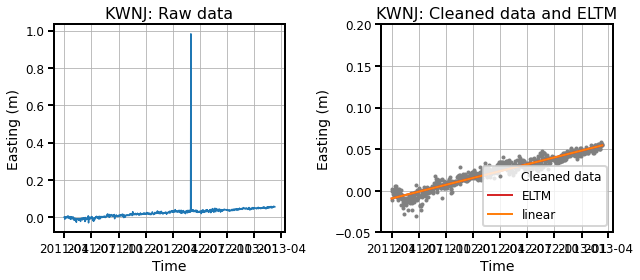

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4173081.67446] [3654100.89118]
1019 2090


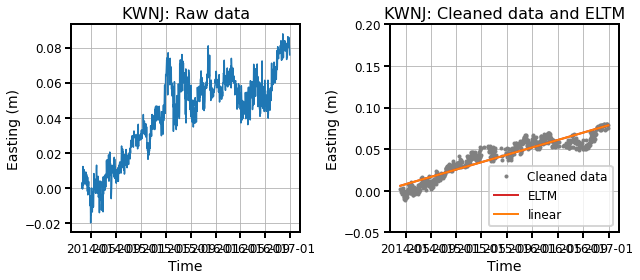

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4311372.00647] [3464865.10949]
710 2082


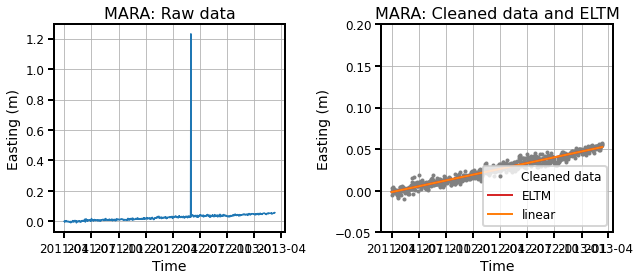

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1068]
[4311371.9657295] [3464865.0824665]
1014 2082


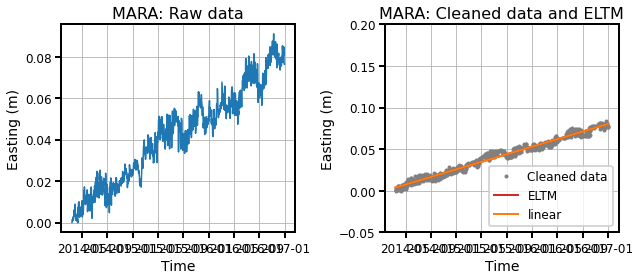

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4089577.15678] [3728622.08121]
709 2088


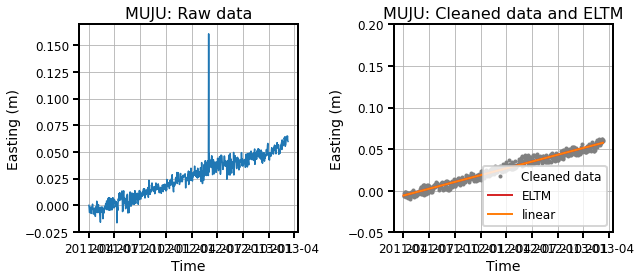

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1070]
[4089577.10287] [3728622.05245]
1018 2088


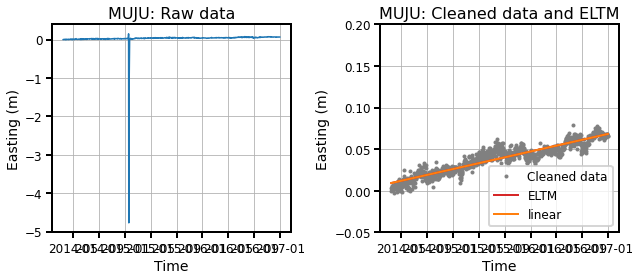

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4133956.24041] [3676317.98268]
709 2089


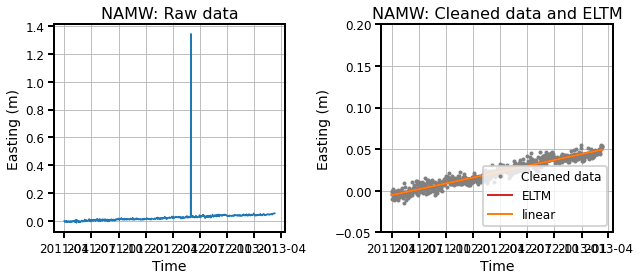

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1070]
[4133956.19485] [3676317.95675]
1019 2089


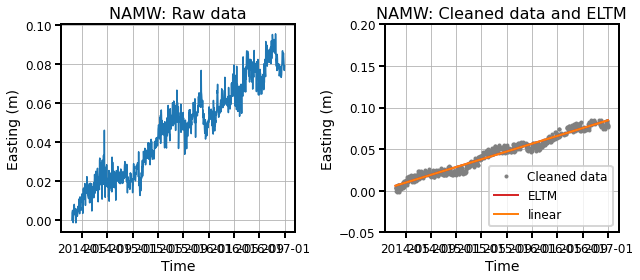

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4110681.08318] [3744932.08852]
705 2085


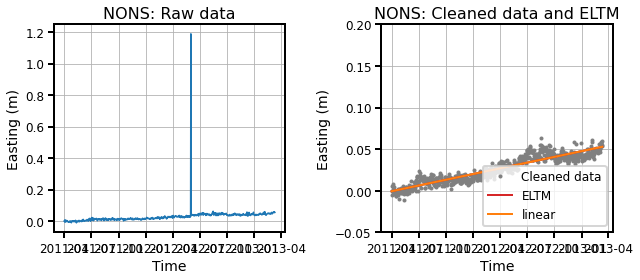

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1066]
[4110681.03396] [3744932.05408]
1019 2085


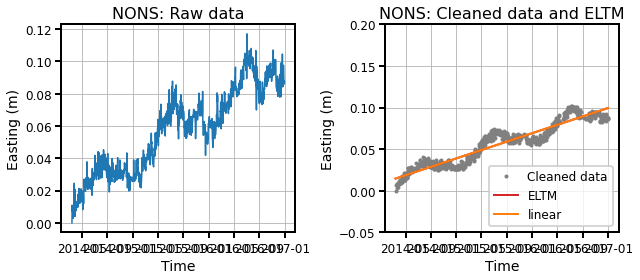

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4046783.51022] [3883270.20664]
710 2090


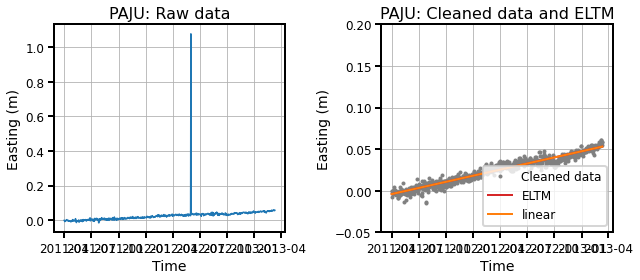

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4046783.45618] [3883270.17799]
1019 2090


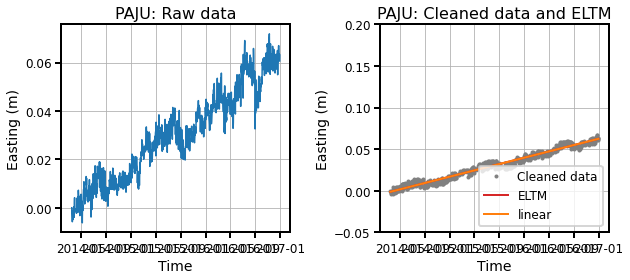

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4049012.00495] [3659187.93705]
703 2083


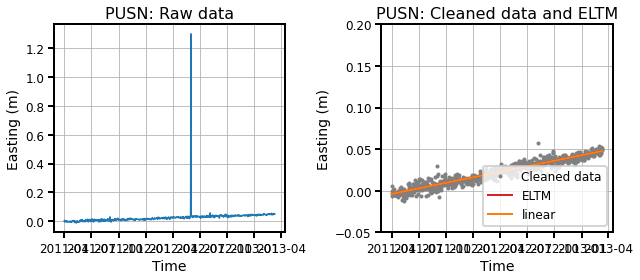

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1064]
[4049011.94405] [3659187.90435]
1019 2083


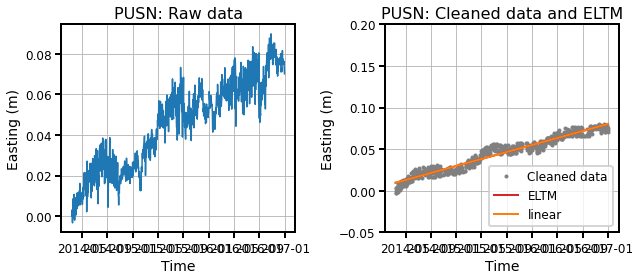

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4111978.64426] [3797578.6756]
710 2090


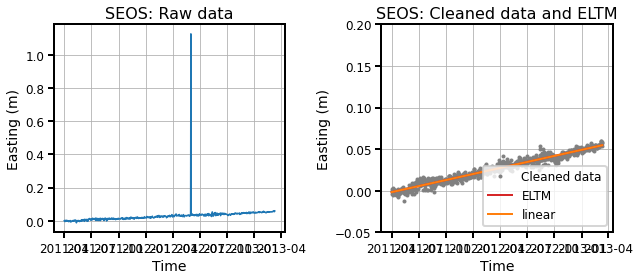

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4111978.60061] [3797578.65117]
1019 2090


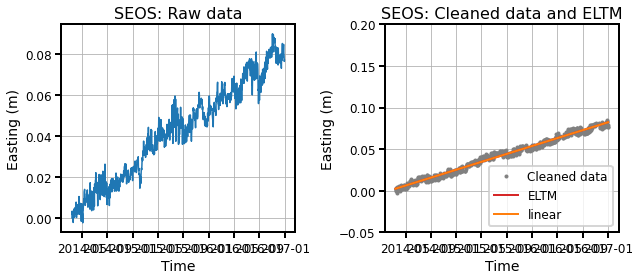

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4043362.81121] [3762213.54145]
710 2089


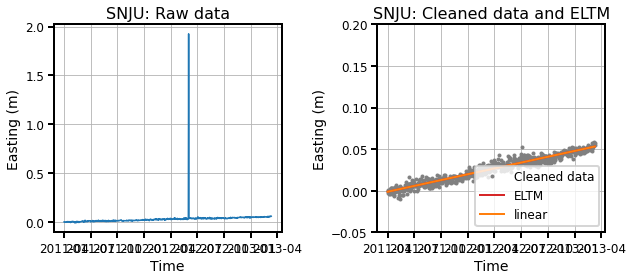

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4043362.76454] [3762213.51609]
1018 2089


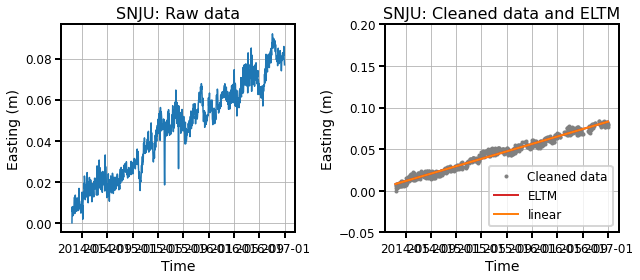

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4152520.97309] [3634026.94802]
709 2088


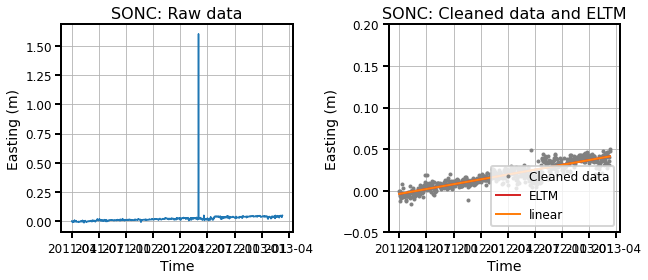

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1070]
[4152520.91619] [3634026.91906]
1018 2088


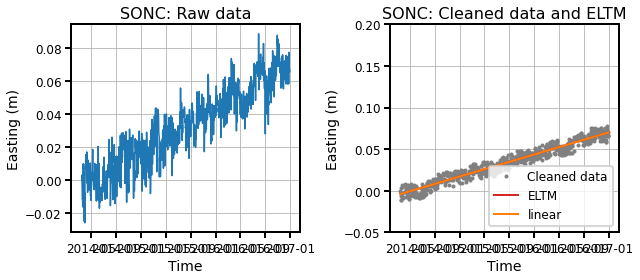

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4055448.93201] [3841819.15936]
710 2090


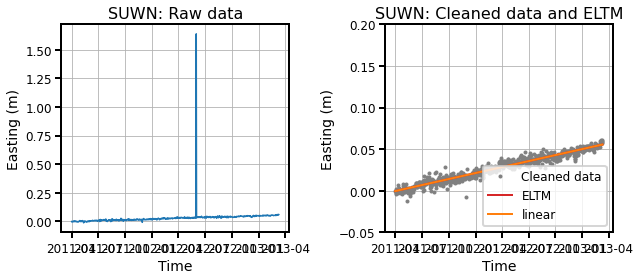

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4055448.88545] [3841819.13275]
1019 2090


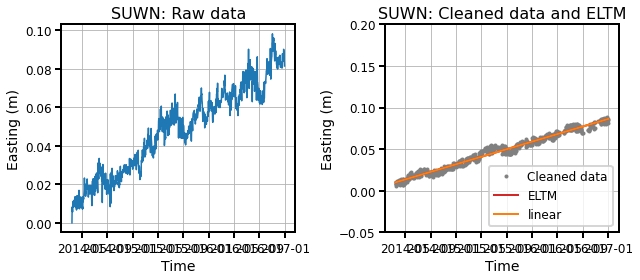

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4030771.62192] [3719838.43106]
710 2083


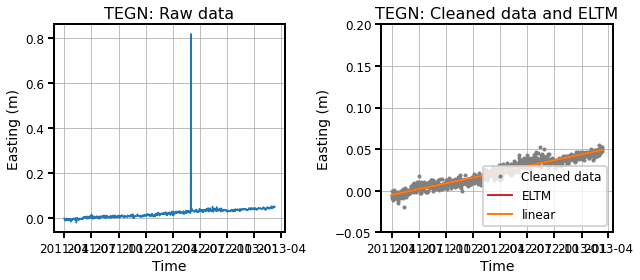

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4030771.57346] [3719838.40935]
1012 2083


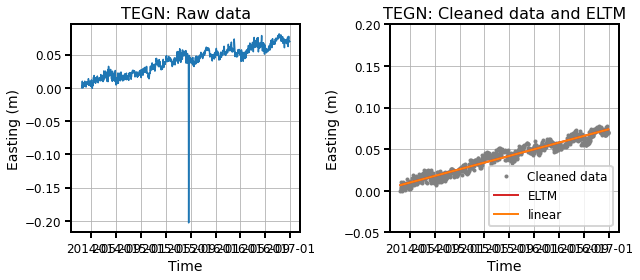

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3834554.74643] [3863307.72473]
687 2045


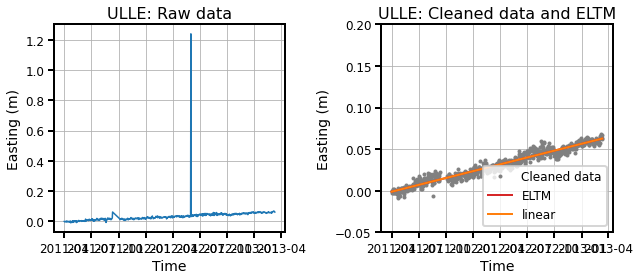

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1026]
[3834554.65981] [3863307.6826]
1019 2045


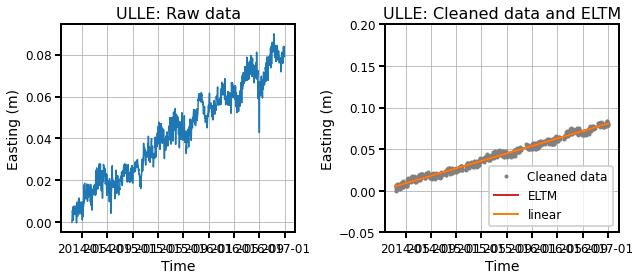

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4004030.53669] [3847323.70225]
710 2090


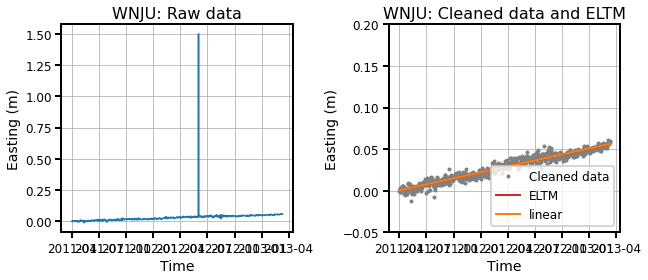

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4004030.49474] [3847323.67785]
1019 2090


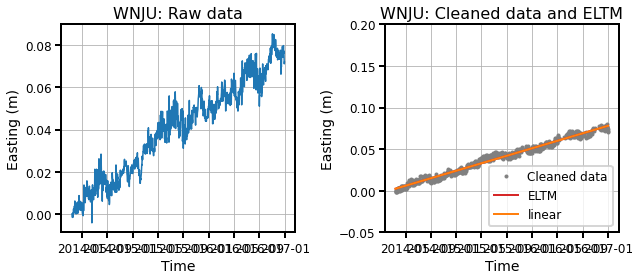

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4015928.2379] [3683580.1344]
710 2090


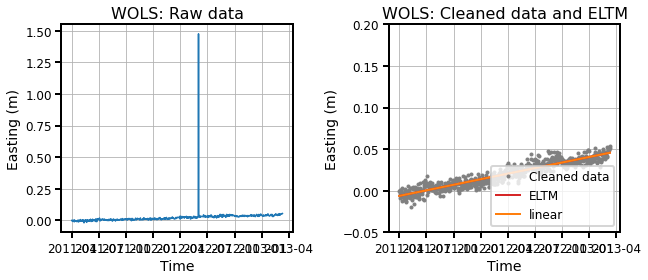

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4015928.17305] [3683580.10474]
1019 2090


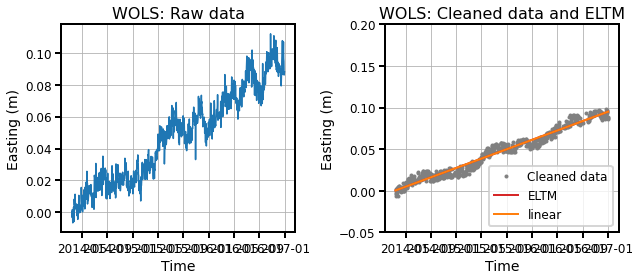

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3940665.28177] [3816730.52498]
710 2088


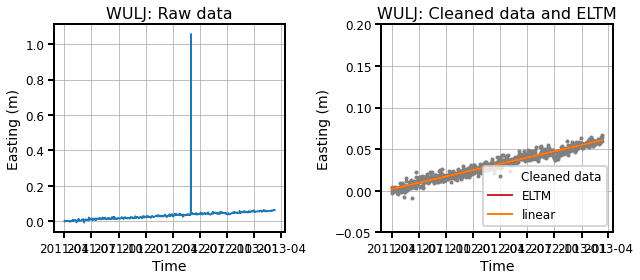

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[3940665.22249] [3816730.50262]
1017 2088


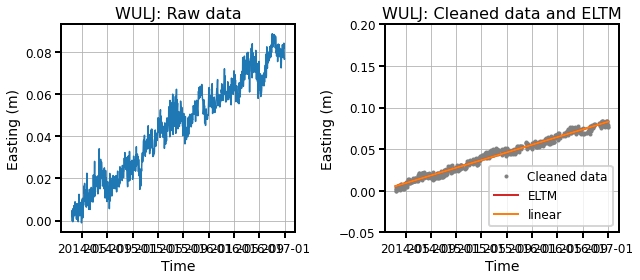

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4021645.51241] [3857572.58788]
710 2090


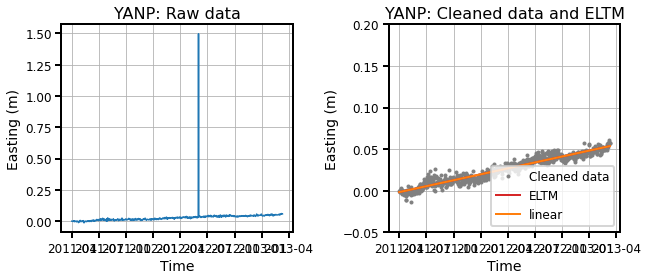

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4021645.46038] [3857572.55504]
1019 2090


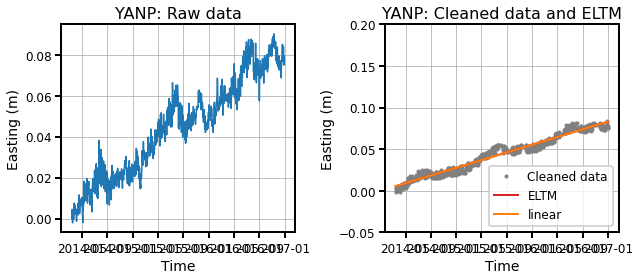

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4012510.9149] [3786513.57346]
709 2089


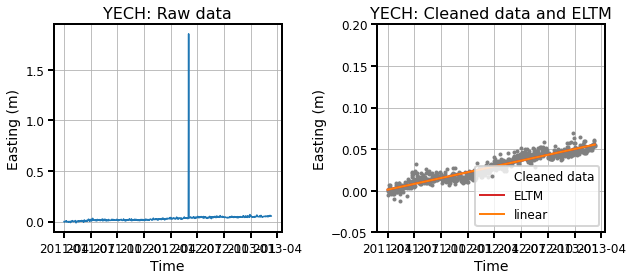

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1070]
[4012510.85631] [3786513.54023]
1019 2089


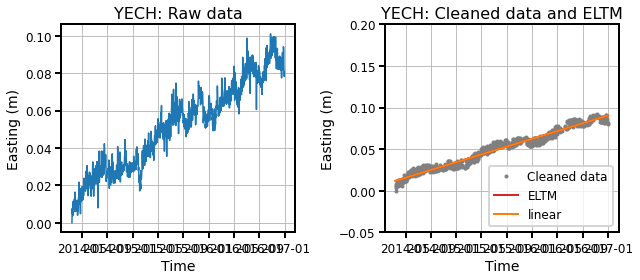

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[4189388.7618] [3663198.86314]
710 2090


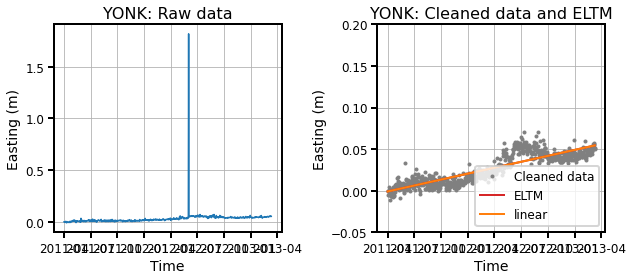

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1071]
[4189388.71086] [3663198.82492]
1019 2090


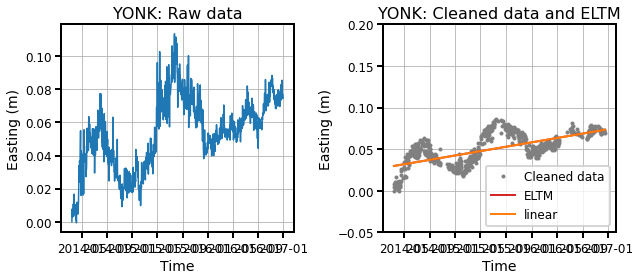

2011-04-01 2011-04-01 2013-03-11 2016-12-31
start_index = [0]
[3984004.02572] [3833703.88995]
708 2088


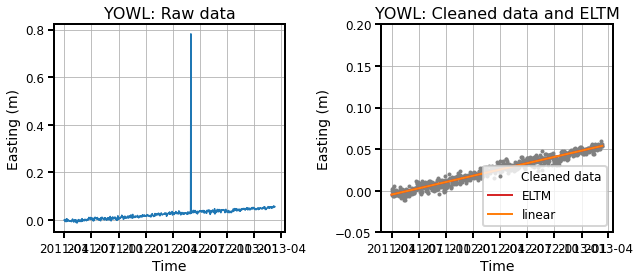

2014-03-14 2011-04-01 2016-12-31 2016-12-31
start_index = [1069]
[3984003.96837] [3833703.86251]
1019 2088


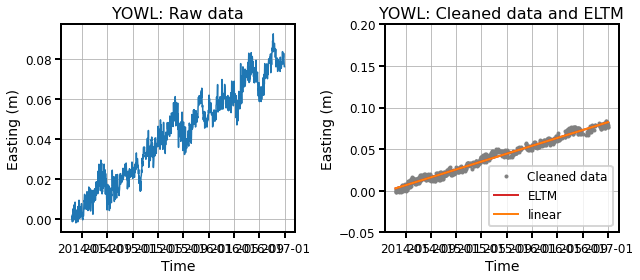

55


In [34]:
# When processing all the stations in a batch:
counter = 0
station_eltm_data_AB = {}
for selected_station in Korea_GPS_Stations.data.keys():
    ecoeffA, ecovA, ncoeffA, ncovA = get_eltm_as_Kim_etal_2018( selected_station, \
                                                    datetime(2011,4,1), datetime(2013,3,11) )
    ecoeffB, ecovB, ncoeffB, ncovB = get_eltm_as_Kim_etal_2018( selected_station, \
                                                    datetime(2014,3,14), datetime(2016,12,31) )
    counter = counter + 1
    station_eltm_data_AB[selected_station] = {'ecoeffA':ecoeffA, 'ecovA':ecovA, \
                                              'ncoeffA':ncoeffA, 'ncovA':ncovA, \
                                              'ecoeffB':ecoeffB, 'ecovB':ecovB, \
                                              'ncoeffB':ncoeffB, 'ncovB':ncovB}
print(counter)

The data set with the problematic stations removed is pickled as `Korea_GPS_Stations_20110401_20161231.p`.
The linear and logarithmic coefficients and associated covariances from the ELTM fitting are saved as `Korea_GPS_Stations_coeff_cov_20110401_20161231.p`. Subsequent processing and analysis can start with loading it.

In [35]:
# Save stations that has data from 2011/04/11 to 2016/09/11.
# with open('Korea_GPS_Stations_20110401_20161231.p', 'wb') as handle:
#     pickle.dump(Korea_GPS_Stations, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Korea_GPS_Stations_coeff_cov_AB.p', 'wb') as handle:
    pickle.dump(station_eltm_data_AB, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Location Map of the GPS Stations

The locations of the GPS stations are plotted for reference.

In [23]:
import pandas as pd
station_locations = pd.read_excel (r'GPS_station_locations.xlsx')
#print (station_locations['Station'])

try: 
    with open( 'Korea_GPS_Stations_coeff_cov_20110401_20161231.p', 'rb' ) as handle:
        Korea_GPS_CoeffCov = pickle.load(handle)
        # This is a dictionary with 55 stations as keys
        # Each item is a dictionary with 4 keys, ecoeff, ecov, ncoeff, ncov.
        print(Korea_GPS_CoeffCov['DAEJ']['ecoeff'])
except FileNotFoundError:
    print("Failed to load the pickled data. Generate ELTM coefficients using GPSdata.ipynb.")

[ 7.52111858e-05 -4.58546762e-03 -1.38652875e-03 -1.80878108e+01
  4.76382753e-03  8.47243846e+01 -7.19859033e-04 -2.21753202e+01
 -1.13390811e-03 -3.81648540e+01  3.26937210e-03]


55


C:\Users\eddy_\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\eddy_\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


55


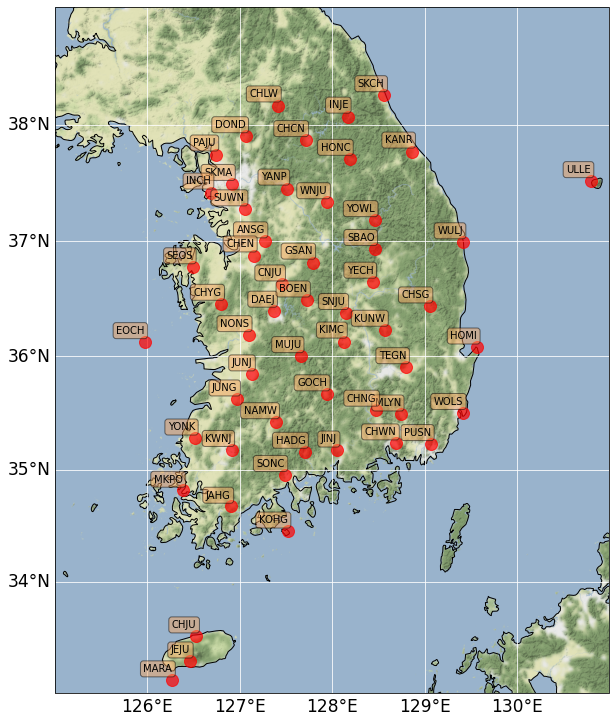

In [24]:
import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(8)

#ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)
ax.set_extent([125, 131, 33, 39], crs=ccrs.PlateCarree())

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 8)
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True, color='white')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([125, 126, 127, 128, 129, 130, 131])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 17, 'color': 'black'}
gl.xlabel_style = {'size': 17, 'color': 'black'}

counter = 0
print(len(Korea_GPS_Stations.data.keys()))
Korea_GPS_Stations_locs = {}
for station in Korea_GPS_Stations.data.keys():
    loc_ind = station_locations.index[station_locations['Station'] == station].to_list()
    if len(loc_ind) == 1:
        counter = counter + 1
        #print("{0} Found index for {1}: {2}".format(counter, station, loc_ind[0]))        
    else:
        print("Location not found: {0}".format(station))
        continue
    lon = station_locations.at[loc_ind[0], 'Longitude (deg)']
    lat = station_locations.at[loc_ind[0], 'Latitude (deg)']
    Korea_GPS_Stations_locs[station] = np.array([lon,lat])
    ax.plot(lon, lat, marker='o', color='red', markersize=12,
            alpha=0.7, transform=ccrs.PlateCarree())
    ax.text(lon, lat+0.1, station,
            verticalalignment='center', horizontalalignment='right',
            transform=ccrs.PlateCarree(),
            bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
print(counter)
plt.show()
fig.savefig("GPS_location_map.pdf")

In [25]:
with open('Korea_GPS_Stations_locations.p', 'wb') as handle:
    pickle.dump(Korea_GPS_Stations_locs, handle, protocol=pickle.HIGHEST_PROTOCOL)